<a href="https://colab.research.google.com/github/eojo91/ds2_2023_summer_ml_project1/blob/joonhoon.lee/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 4일 (금) 자정
- 제출 내용: `4. 구현` 셀에 `LRClassifier` 변수를 구현하고, `Project1.ipynb`를 제출
- 제출 방법: `ta_ml@hcs.snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 1`
- 점수 비중: 10%


### 채점 기준 [총 100점]
1. `5. 테스트` 셀이 잘 실행되어야 합니다. [+100점]
2. `LRClassifier`는 Logistic Regression을 이용해서 분류를 수행해야 합니다. [-100점]
3. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `4. 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. Project 1에서 성능은 채점 기준에 들어가지 않습니다.
2. `sklearn` 외의 다른 라이브러리를 사용해도 됩니다.

---
## 목차
1. 프로젝트 개요
2. 데이터<br/>
  2.1. 데이터 로드 방법<br/>
  2.2. 데이터 개요<br/>
  2.3. 데이터 샘플 예제<br/>
3. `KNNClassifier` 예제
4. 구현
5. 테스트

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [1]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. 데이터
#### 2.1. 데이터 로드

In [2]:
def load_data(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
    groups = np.stack(df['Subject'])  # For LeaveOneGroupOut

    return X, Y, groups

In [3]:
def load_data_df(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    return df

In [4]:
X, Y, groups = load_data(local=False)

print(X.shape, Y.shape, groups.shape)

(13940, 500, 3) (13940,) (13940,)


#### 2.2. 데이터 개요
- 각 샘플은 `Subject`, `Data`, `Motion` 값으로 이루어져 있습니다.
  - `Subject`: 실험자 ID (`int` 타입)
  - `Data`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Motion`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...

- `Data` 정보를 가지고 `Motion` 값을 유추해야합니다.
- `Subject`는 Cross Validation에 활용하기 위해 제공됩니다. Cross Validation의 경우 `CrossValidation.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

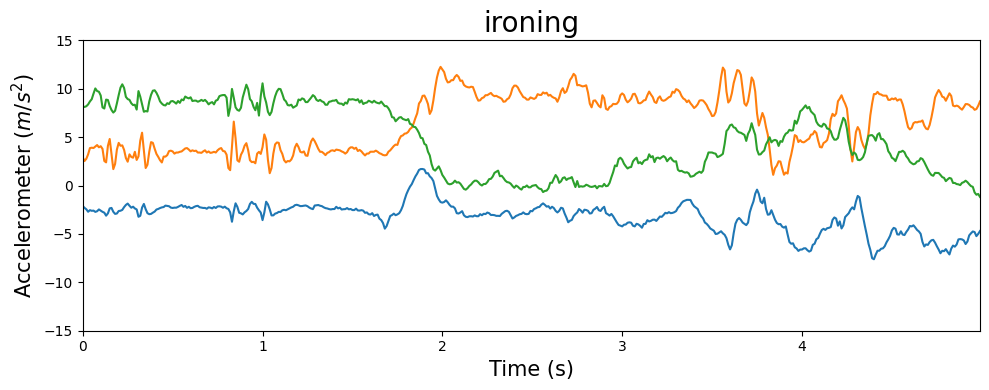

In [ ]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### 3. `KNNClassifier` 예제
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다. 채점기준을 참고해주세요.

```python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.
KNNClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier()),
])
```

#### `KNNClassifier` 구현 순서
##### a. `extract_features_from_a_single_sample`
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 추가적인 특성들을 구현할 때 아래 목록을 참고하실 수 있습니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

##### b. 전처리기 (Preprocessor) 추가
- a.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [`sklearn.preprocessing` documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.


##### c. 분류기 튜닝
- a.에서 어떤 특성을 사용할지, b.에서 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.

### 4. 구현

## 4.1 데이터 체크

['Nordic walking' 'ascending stairs' 'cycling' 'descending stairs'
 'ironing' 'lying' 'rope jumping' 'running' 'sitting' 'standing'
 'vacuum cleaning' 'walking']
[1358  787 1135  689 1834 1392  216  659 1366 1400 1290 1814]


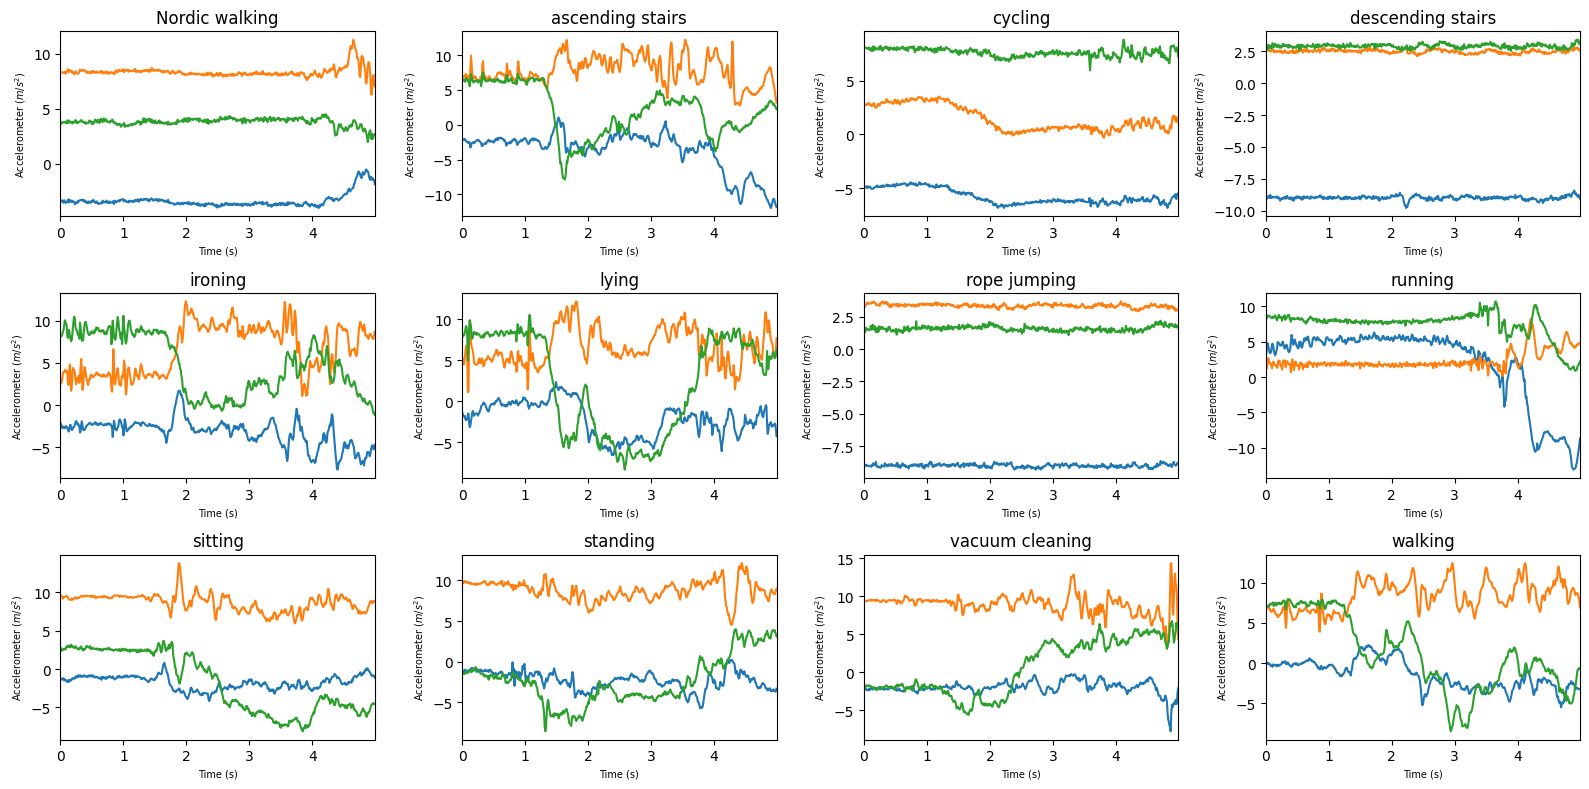

In [ ]:
# 우종남님이 주신 코드
y_name, y_first_index, y_counts = np.unique(Y, return_index=True, return_counts=True)
print(y_name)
print(y_counts)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(y_first_index)):
  idx = y_first_index[i]
  X_sample, Y_sample = X[idx], Y[idx]
  time_stamps = np.arange(0, len(X_sample)) / 100

  ax = axes[i // 4, i % 4]

  ax.plot(time_stamps, X_sample)

  ax.set_title(Y_sample, fontsize=12)
  ax.set_xlabel('Time (s)', fontsize=7)
  ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  ax.set_xlim(min(time_stamps), max(time_stamps))

  fig.tight_layout()
  fig.show()

## 4.2 센서 데이터를 DataFrame으로 만들기

In [5]:
# 센서 데이터를 DataFrame으로 만들기

import pandas as pd

m, n, r = X.shape
out_arr = np.column_stack((np.repeat(np.arange(m), n), X.reshape(m*n, -1)))
df_x = pd.DataFrame(out_arr)
df_x.columns = ['subject', 'X', 'Y', 'Z']
df_x['subject'] = df_x['subject'].astype('int')
df_x.head()

,subject,X,Y,Z
0,0,-2.11549,2.91050,8.15791
1,0,-2.30844,2.53223,8.11781
2,0,-2.45532,2.76170,8.19181
3,0,-2.70996,3.22069,8.37888
4,0,-2.54358,3.86718,8.68709


In [ ]:
# 번호가 0번인 사람의 데이터 수 500개
df_x[df_x['subject'] == 0]

,subject,X,Y,Z
0,0,-2.11549,2.91050,8.157910
1,0,-2.30844,2.53223,8.117810
2,0,-2.45532,2.76170,8.191810
3,0,-2.70996,3.22069,8.378880
4,0,-2.54358,3.86718,8.687090
...,...,...,...,...
495,0,-4.74585,8.05478,-0.135144
496,0,-4.80529,7.82240,-0.712561
497,0,-5.22847,7.89948,-0.950084
498,0,-4.99666,8.23985,-0.870785


In [ ]:
# 번호가 100번인 사람의 데이터 수 500개
df_x[df_x['subject'] == 100]

,subject,X,Y,Z
50000,100,-6.12349,6.10258,5.20055
50001,100,-6.20067,5.87553,5.20016
50002,100,-6.27330,5.72537,5.31504
50003,100,-5.84665,5.76278,5.62921
50004,100,-5.16539,6.47737,5.52154
...,...,...,...,...
50495,100,-3.72565,6.99743,5.54135
50496,100,-3.91032,6.84847,5.69304
50497,100,-3.94089,7.11568,5.84563
50498,100,-3.27886,6.80289,5.39475


## 4.3 Y 데이터를 DataFrame으로 변환

### 4.3.1 DataFrame 변환

In [8]:
df_y = pd.DataFrame(Y)
df_y.columns = ['motion']
df_y['subject'] = df_y.index
df_y.head()


,motion,subject
0,ironing,0
1,ironing,1
2,ironing,2
3,ironing,3
4,ironing,4


In [9]:
df = pd.merge(left=df_x, right=df_y, how='left', on='subject')
df.head()

,subject,X,Y,Z,motion
0,0,-2.11549,2.91050,8.15791,ironing
1,0,-2.30844,2.53223,8.11781,ironing
2,0,-2.45532,2.76170,8.19181,ironing
3,0,-2.70996,3.22069,8.37888,ironing
4,0,-2.54358,3.86718,8.68709,ironing


### 4.3.2 Motion 종류

In [ ]:
pd.DataFrame(df_y['motion'].unique())

,0
0,ironing
1,standing
2,descending stairs
3,lying
4,ascending stairs
5,sitting
6,walking
7,vacuum cleaning
8,cycling
9,Nordic walking


In [ ]:
df_y['subject'] = df_y.index

In [ ]:
df_y.head()

,motion,subject
0,ironing,0
1,ironing,1
2,ironing,2
3,ironing,3
4,ironing,4


# 그래프로 확인

In [ ]:
df.groupby(['subject'], as_index=False).mean()

<ipython-input-58-282af842be65>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['subject'], as_index=False).mean()


,subject,X,Y,Z
0,0,-3.190969,6.523282,4.731869
1,1,-4.019252,7.320525,3.331382
2,2,-4.602343,8.084341,2.453566
3,3,-3.245236,7.469662,3.259032
4,4,-1.184455,6.880556,3.319907
...,...,...,...,...
13935,13935,1.103380,9.527969,-2.608907
13936,13936,1.260070,9.382145,-2.654792
13937,13937,1.330339,9.589991,-2.551218
13938,13938,0.538177,9.400981,-2.203052


## 1. ironing

In [ ]:
df[df['motion'] == 'ironing']

,subject,X,Y,Z,motion
0,0,-2.11549,2.91050,8.157910,ironing
1,0,-2.30844,2.53223,8.117810,ironing
2,0,-2.45532,2.76170,8.191810,ironing
3,0,-2.70996,3.22069,8.378880,ironing
4,0,-2.54358,3.86718,8.687090,ironing
...,...,...,...,...,...
6066495,12132,-2.57671,-9.60778,-0.389453,ironing
6066496,12132,-2.64989,-9.45510,-0.352577,ironing
6066497,12132,-2.49819,-9.56975,-0.311431,ironing
6066498,12132,-2.61396,-9.72097,-0.351142,ironing


In [ ]:
df['motion'].unique()[0]

'ironing'

In [ ]:
motion_unique = df['motion'].unique()
a1 = []
a2 = []
a3 = []

for i in range(len(df['motion'].unique())):
# for i in range(0, 1):


  data = df[df['motion'] == motion_unique[i]]
  a1.append(data['X'])
  a2.append(data['Y'])
  a3.append(data['Z'])


In [ ]:
a1[0]

0         -2.11549
1         -2.30844
2         -2.45532
3         -2.70996
4         -2.54358
            ...   
6066495   -2.57671
6066496   -2.64989
6066497   -2.49819
6066498   -2.61396
6066499   -2.64453
Name: X, Length: 917000, dtype: float64

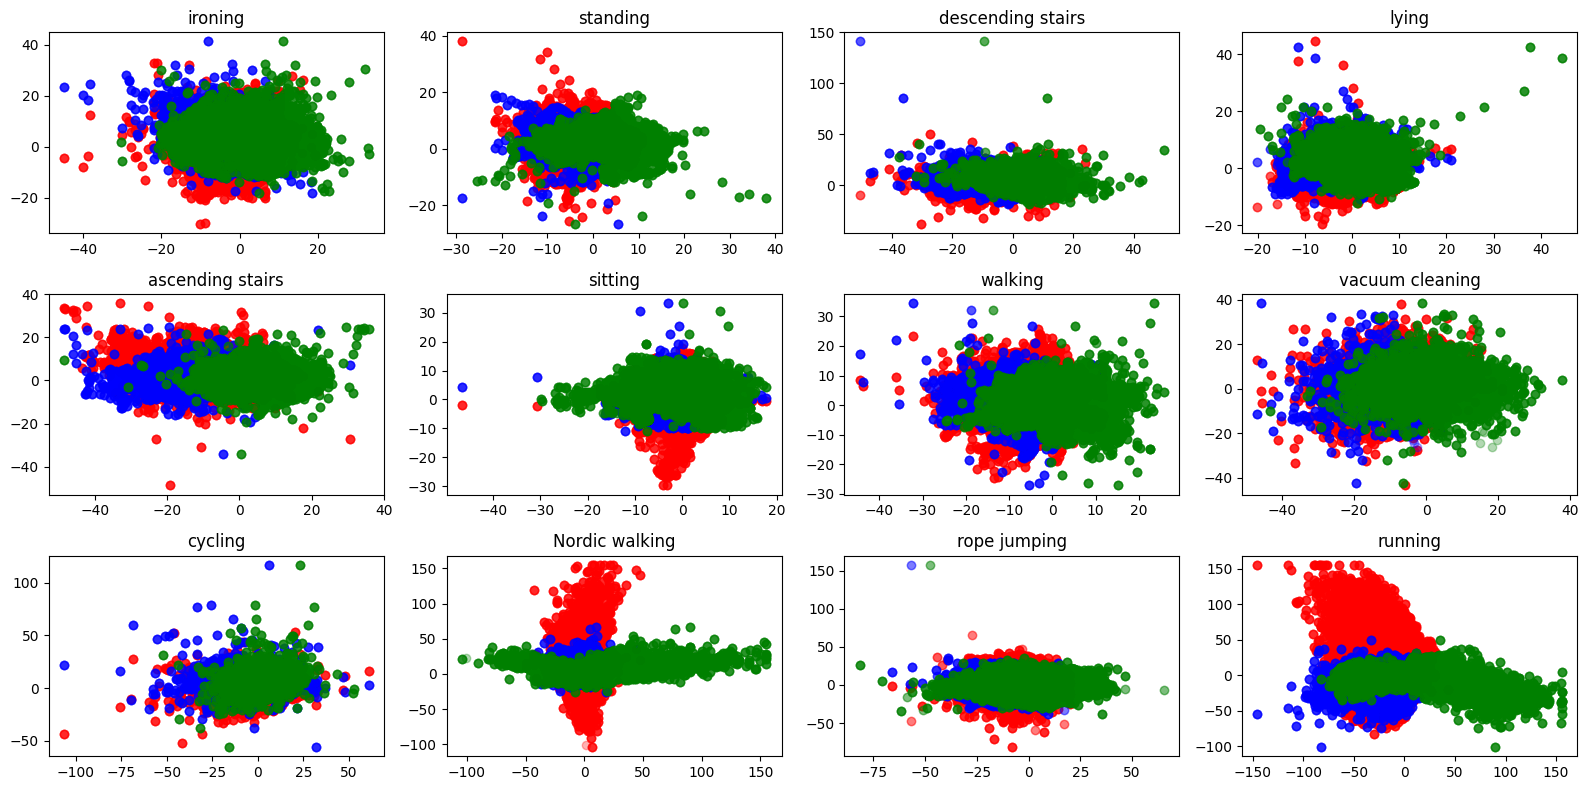

In [ ]:


fig, axes = plt.subplots(3, 4, figsize=(16, 8))

# for i in range(0, 1):
for i in range(len(df['motion'].unique())):
  ax = axes[i // 4, i % 4]

  ax.scatter(a1[i], a2[i], color='r', alpha=0.3)
  ax.scatter(a1[i], a3[i], color='b', alpha=0.3)
  ax.scatter(a2[i], a3[i], color='g', alpha=0.3)

  ax.set_title(motion_unique[i], fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

### 평균으로 그래프 그리기

In [12]:
df_mean = df.groupby(['subject', 'motion'], as_index=False).mean()
df_mean.head()

,subject,motion,X,Y,Z
0,0,ironing,-3.190969,6.523282,4.731869
1,1,ironing,-4.019252,7.320525,3.331382
2,2,ironing,-4.602343,8.084341,2.453566
3,3,ironing,-3.245236,7.469662,3.259032
4,4,ironing,-1.184455,6.880556,3.319907


In [13]:
motion_unique = df_mean['motion'].unique()
a1 = []
a2 = []
a3 = []

for i in range(len(motion_unique)):
  data = df_mean[df_mean['motion'] == motion_unique[i]]
  a1.append(data['X'])
  a2.append(data['Y'])
  a3.append(data['Z'])


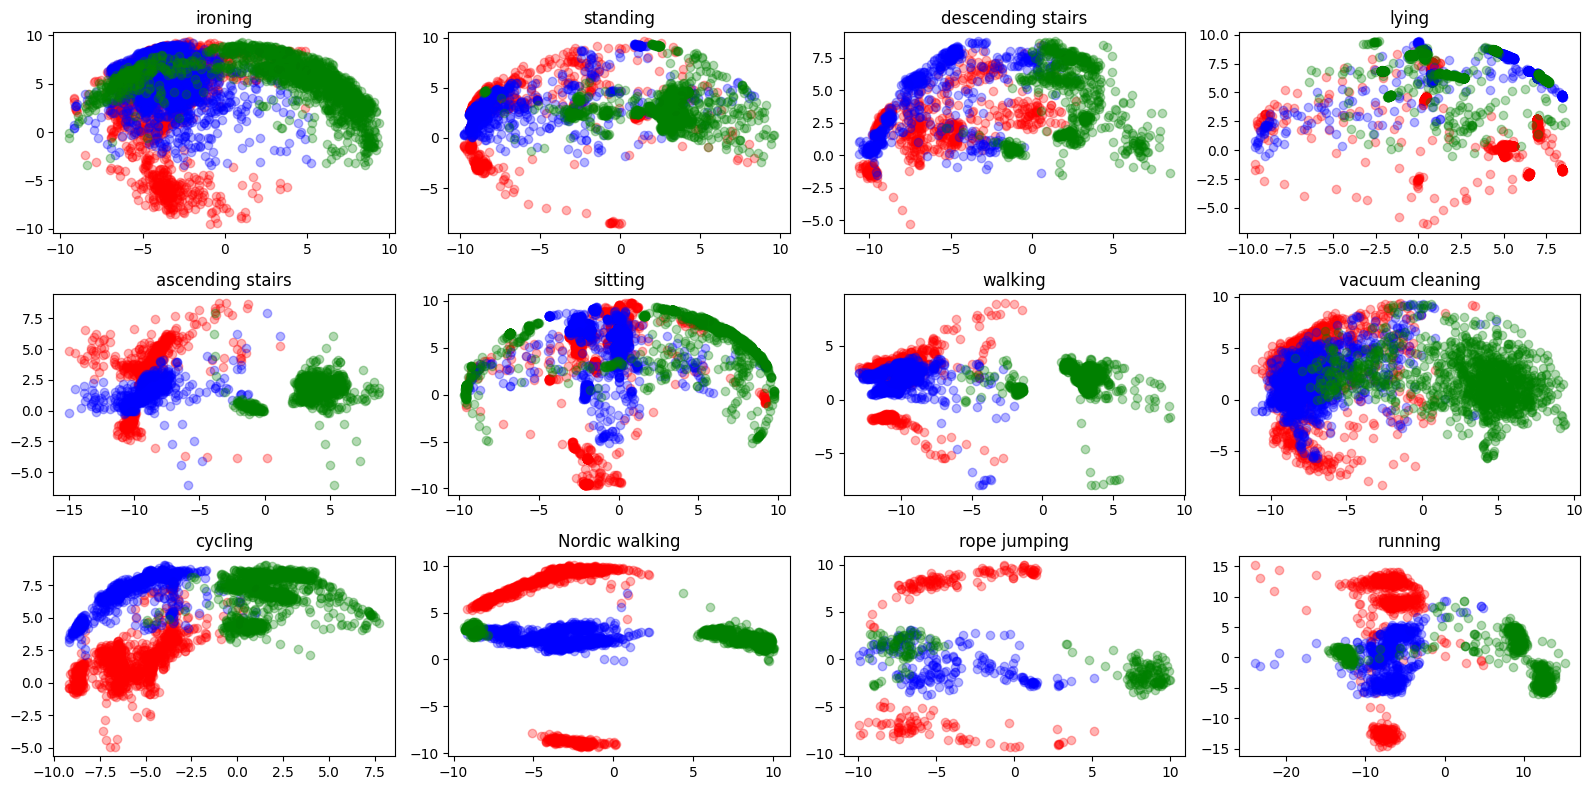

In [15]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(motion_unique)):
  ax = axes[i // 4, i % 4]

  ax.scatter(a1[i], a2[i], color='r', alpha=0.3)
  ax.scatter(a1[i], a3[i], color='b', alpha=0.3)
  ax.scatter(a2[i], a3[i], color='g', alpha=0.3)

  ax.set_title(motion_unique[i], fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

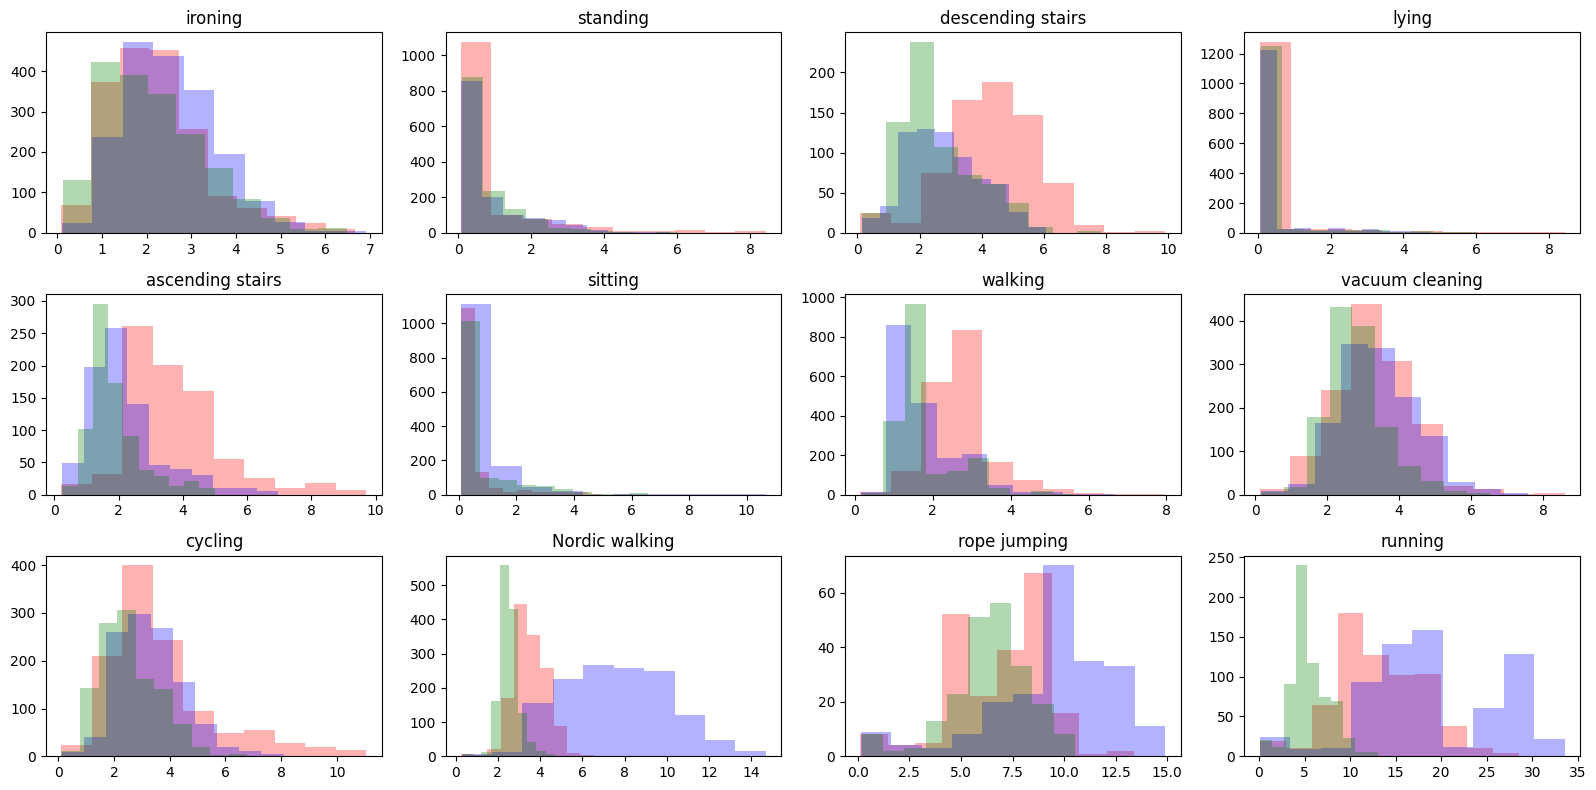

In [19]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for i in range(len(motion_unique)):
  ax = axes[i // 4, i % 4]

  ax.hist(a1[i], color='r', alpha=0.3)
  ax.hist(a2[i], color='b', alpha=0.3)
  ax.hist(a3[i], color='g', alpha=0.3)

  ax.set_title(motion_unique[i], fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

### 표준편차로 그래프 그리기

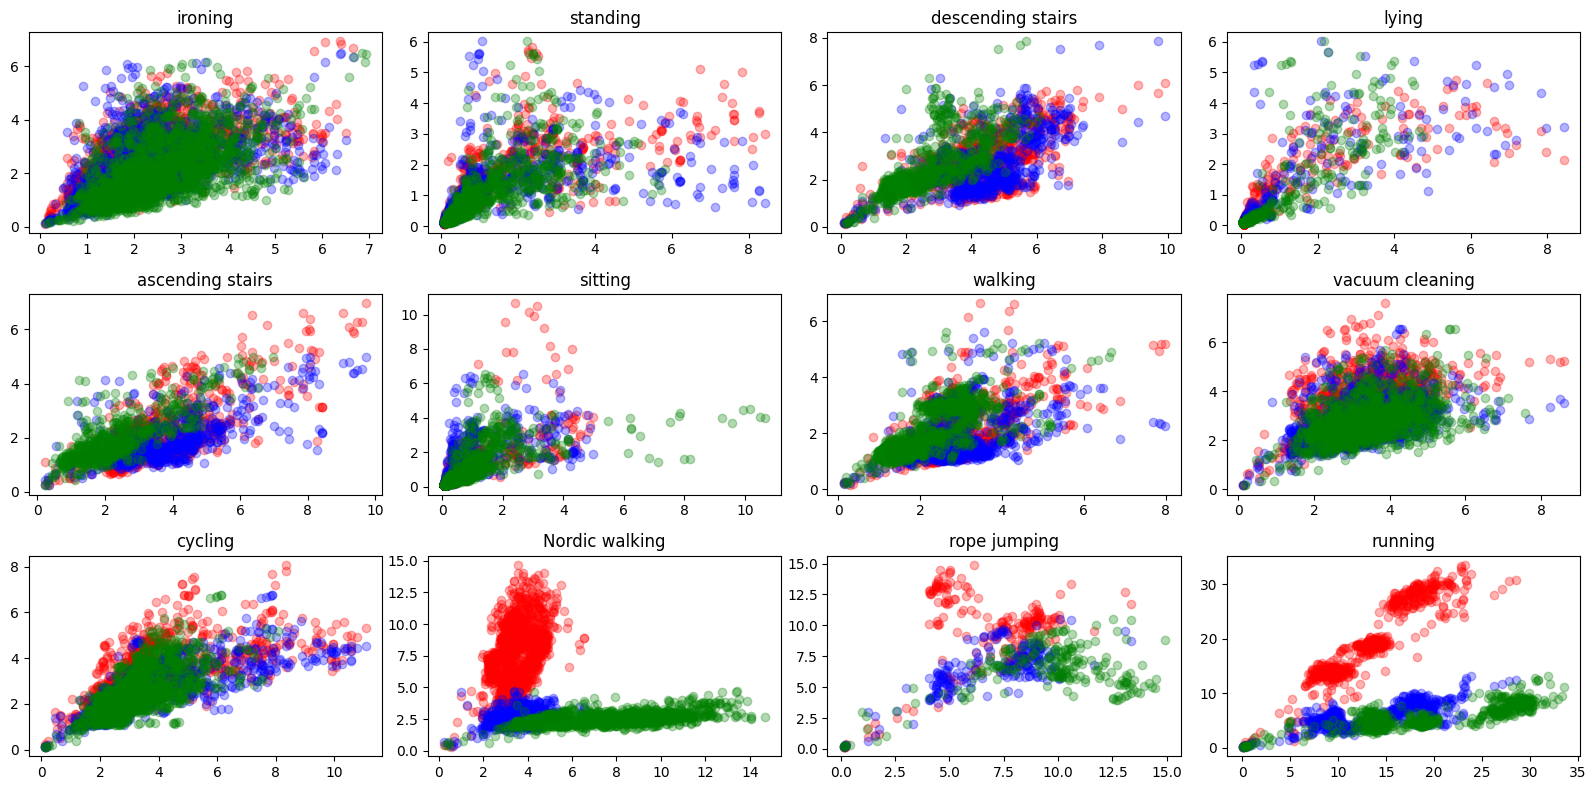

In [16]:
df_data = df.groupby(['subject', 'motion'], as_index=False).std()
motion_unique = df_data['motion'].unique()
a1 = []
a2 = []
a3 = []

for i in range(len(motion_unique)):
  data = df_data[df_data['motion'] == motion_unique[i]]
  a1.append(data['X'])
  a2.append(data['Y'])
  a3.append(data['Z'])

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(motion_unique)):
  ax = axes[i // 4, i % 4]

  ax.scatter(a1[i], a2[i], color='r', alpha=0.3)
  ax.scatter(a1[i], a3[i], color='b', alpha=0.3)
  ax.scatter(a2[i], a3[i], color='g', alpha=0.3)

  ax.set_title(motion_unique[i], fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

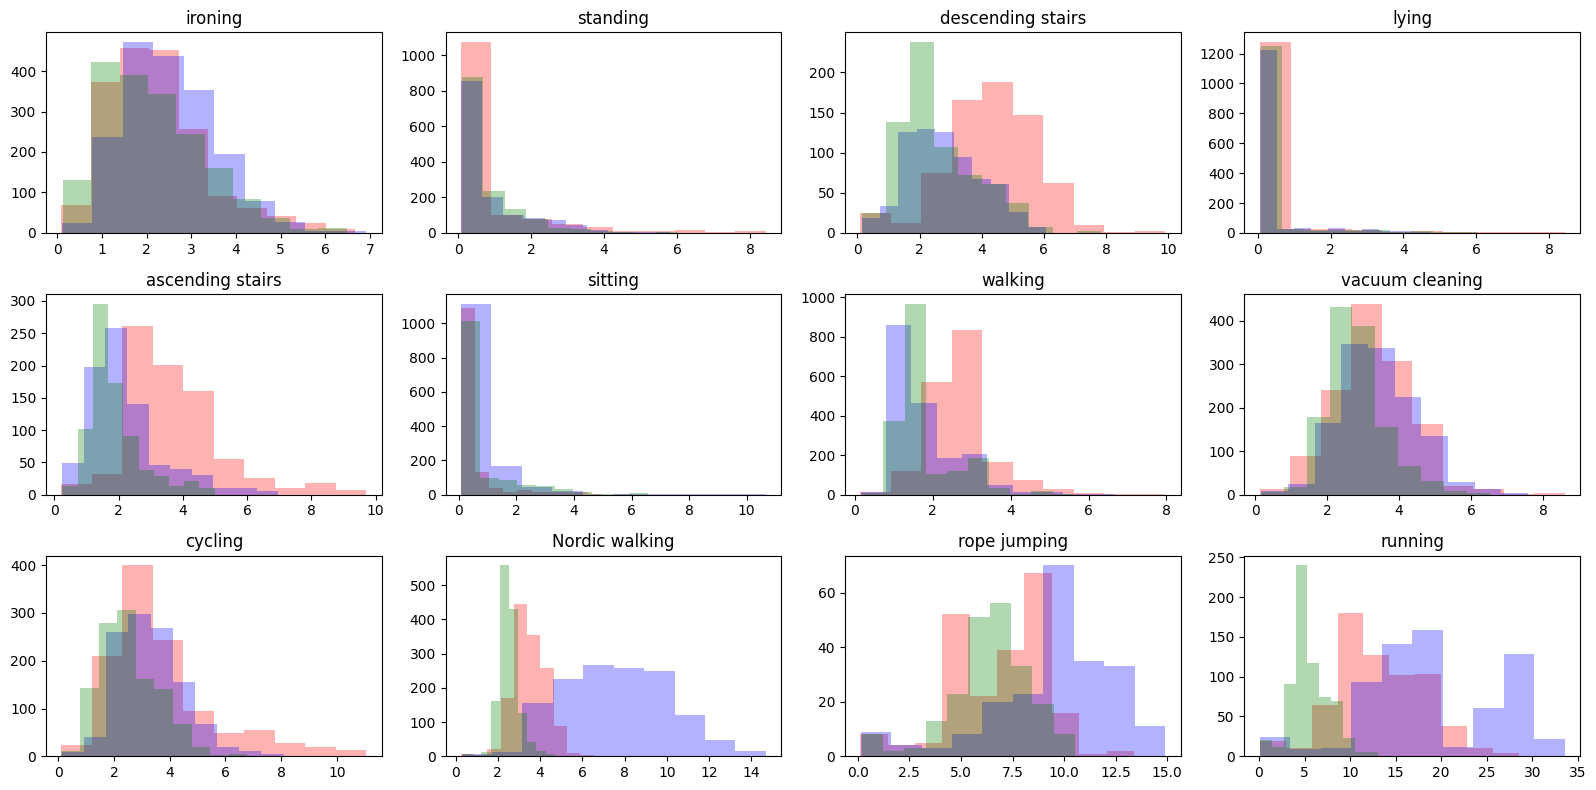

In [18]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for i in range(len(motion_unique)):
  ax = axes[i // 4, i % 4]

  ax.hist(a1[i], color='r', alpha=0.3)
  ax.hist(a2[i], color='b', alpha=0.3)
  ax.hist(a3[i], color='g', alpha=0.3)

  ax.set_title(motion_unique[i], fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

### FFT

In [ ]:
X_fft = np.abs(np.fft.fft(X, axis=0))[1:]

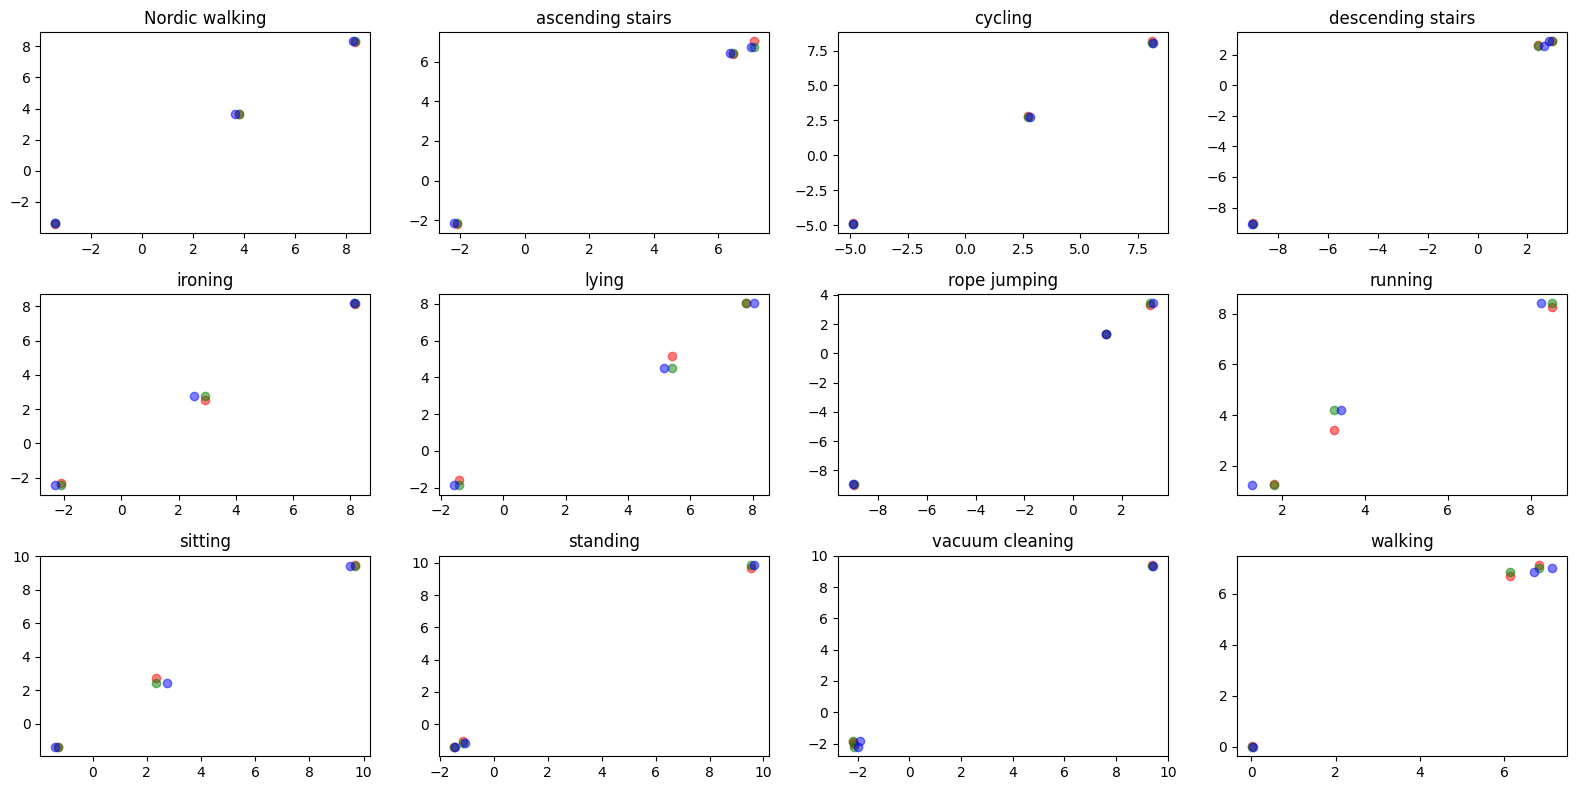

In [25]:
# 우종남님이 주신 코드 활용
y_name, y_first_index, y_counts = np.unique(Y, return_index=True, return_counts=True)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(y_first_index)):
  idx = y_first_index[i]
  X_sample, Y_sample = X[idx], Y[idx]
  # time_stamps = np.arange(0, len(X_sample)) / 100
  X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]


  ax = axes[i // 4, i % 4]

  ax.scatter(X_sample[0], X_sample[1], color='r', alpha=0.5)
  ax.scatter(X_sample[0], X_sample[2], color='g', alpha=0.5)
  ax.scatter(X_sample[1], X_sample[2], color='b', alpha=0.5)

  ax.set_title(Y_sample, fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

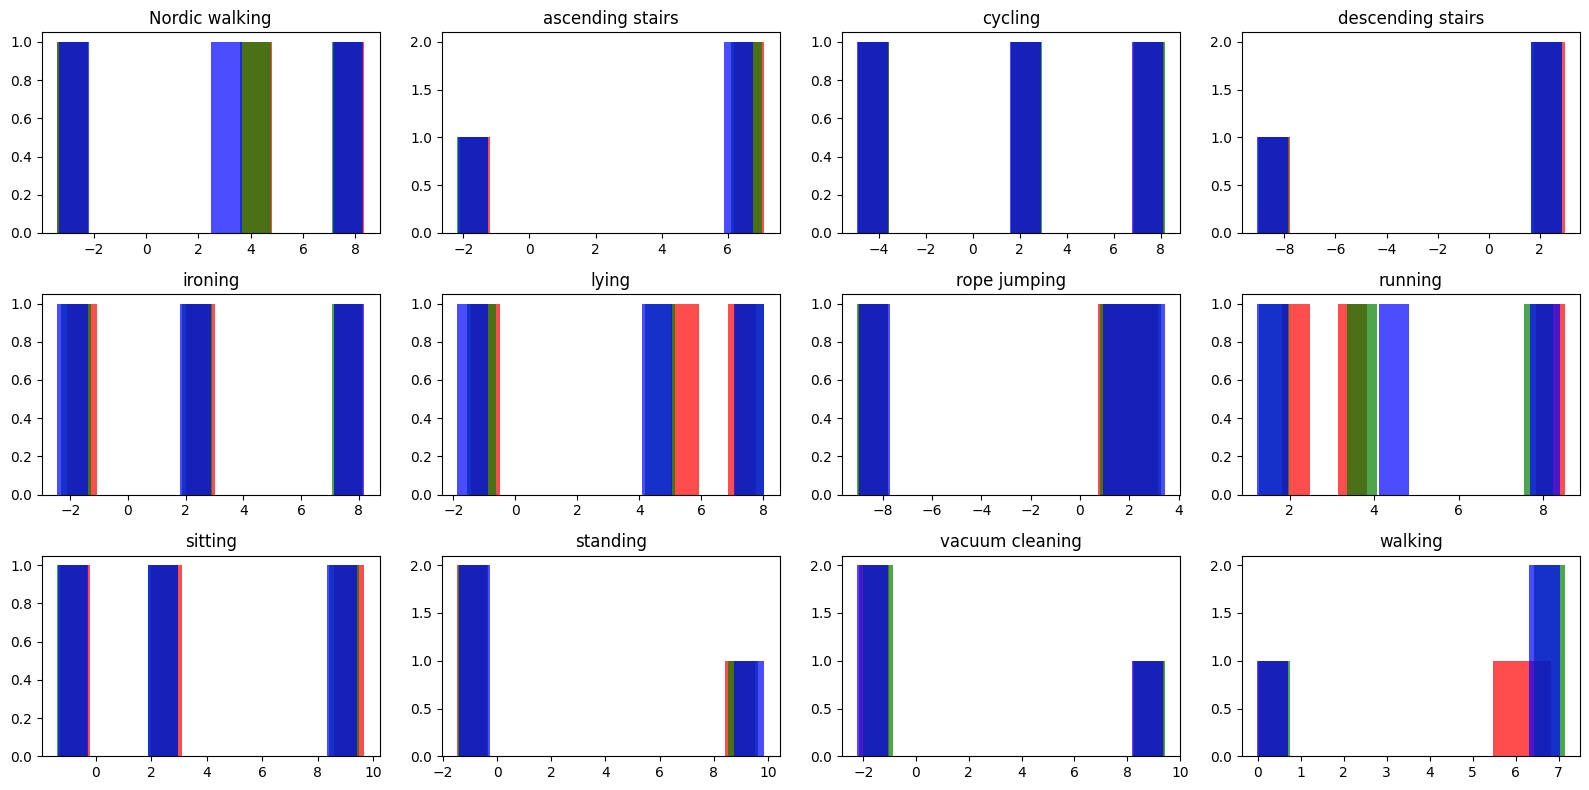

In [24]:
# 우종남님이 주신 코드 활용
y_name, y_first_index, y_counts = np.unique(Y, return_index=True, return_counts=True)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(y_first_index)):
  idx = y_first_index[i]
  X_sample, Y_sample = X[idx], Y[idx]
  # time_stamps = np.arange(0, len(X_sample)) / 100
  X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]


  ax = axes[i // 4, i % 4]

  ax.hist(X_sample[0], color='r', alpha=0.7)
  ax.hist(X_sample[1], color='g', alpha=0.7)
  ax.hist(X_sample[2], color='b', alpha=0.7)

  ax.set_title(Y_sample, fontsize=12)
  # ax.set_xlabel('Time (s)', fontsize=7)
  # ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  # ax.set_xlim(min(time_stamps), max(time_stamps))

fig.tight_layout()
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
############################################################
# Implement your own LRClassifier in this cell
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]

    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)

    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.


############################################################

In [ ]:
LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', MinMaxScaler()),
    ('preprocessor', PCA()),
    ('그냥해봄', QuantileTransformer()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

### 5. Cross-validation with subjects

In [ ]:
X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.40971132774003316


In [ ]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', RobustScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.443528179696479


In [ ]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler, MaxAbsScaler

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', MaxAbsScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.41847161176329334


In [ ]:

def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]

    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    min = np.min(X_sample, axis=0)
    max = np.max(X_sample, axis=0)

    features = np.hstack([mean, std, min, max])
    return features

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, QuantileTransformer, RobustScaler, MaxAbsScaler

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('normalizer', RobustScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs')),
])

X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.46055809564044276
